In [ ]:
import numpy as np

X = np.load('/content/content/X_train.npy')
Y = np.load('/content/content/Y_train.npy')
image1 = X[0][:, :, :3]  # First 3 channels
image2 = X[0][:, :, 3:]  # Last 3 channels


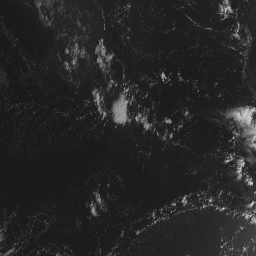

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(Y[0]*255.0)

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, ReLU, Add, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer


# Custom Separable Convolution Layer
class SeparableConvLayer(Layer):
    def __init__(self, kernel_size, **kwargs):
        super(SeparableConvLayer, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def build(self, input_shape):
        # Initialize vertical and horizontal kernels
        self.kernel_h = self.add_weight(
            shape=(1, self.kernel_size, input_shape[-1], 1),
            initializer="glorot_uniform",
            trainable=True,
            name="kernel_h"
        )
        self.kernel_v = self.add_weight(
            shape=(self.kernel_size, 1, input_shape[-1], 1),
            initializer="glorot_uniform",
            trainable=True,
            name="kernel_v"
        )

    def call(self, inputs):
        # Apply vertical and horizontal convolutions sequentially
        conv_v = tf.nn.depthwise_conv2d(
            inputs, self.kernel_v, strides=[1, 1, 1, 1], padding="SAME"
        )
        conv_h = tf.nn.depthwise_conv2d(
            conv_v, self.kernel_h, strides=[1, 1, 1, 1], padding="SAME"
        )
        return conv_h


# Network Definition
def create_sepconv_network(input_shape=(256, 256, 3)):
    # Input layers for two frames
    input_I1 = Input(shape=input_shape, name="Frame_I1")
    input_I2 = Input(shape=input_shape, name="Frame_I2")

    # Encoder
    def encoder_block(x, filters, kernel_size=3, strides=2):
        x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
        x = ReLU()(x)
        return x

    # Decoder
    def decoder_block(x, skip_connection, filters, kernel_size=3):
        x = UpSampling2D(size=2)(x)
        x = Conv2D(filters, kernel_size, padding='same')(x)
        x = Add()([x, skip_connection])
        x = ReLU()(x)
        return x

    # Shared Encoder for feature extraction
    concat_inputs = concatenate([input_I1, input_I2], axis=-1)
    encoder_outputs = []
    x = concat_inputs
    for filters in [32, 64, 128, 256, 512]:
        x = encoder_block(x, filters)
        encoder_outputs.append(x)

    # Decoder
    for filters, skip in zip([256, 128, 64, 32], reversed(encoder_outputs[:-1])):
        x = decoder_block(x, skip, filters)

    # Sub-networks to estimate kernels
    def kernel_estimator(x, name):
        kernel = Conv2D(1, kernel_size=3, padding='same', activation='linear', name=name)(x)
        return kernel

    k1_h = kernel_estimator(x, "k1_h")
    k1_v = kernel_estimator(x, "k1_v")
    k2_h = kernel_estimator(x, "k2_h")
    k2_v = kernel_estimator(x, "k2_v")

    # Synthesis Layer (Separable Convolution)
    output_I1 = SeparableConvLayer(kernel_size=51, name="sepconv_I1")(input_I1)
    output_I2 = SeparableConvLayer(kernel_size=51, name="sepconv_I2")(input_I2)

    # Combine results from both frames
    output_frame = Add()([output_I1, output_I2])

    # Define model
    model = Model(inputs=[input_I1, input_I2], outputs=output_frame, name="SepConv_Interpolation")
    return model


# Instantiate and compile the model
model = create_sepconv_network(input_shape=(256, 256, 3))

In [ ]:
def l1_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

model.compile(optimizer='adam', loss=l1_loss)

In [ ]:
history = model.fit(
    x=[X[:, :, :, :3], X[:, :, :, 3:]],  # Pass i0 and i2 separately
    y=Y,
    epochs=50,
    batch_size=16
)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.1277
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0877
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0730
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0644
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0627
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0599
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0560
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0562
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0512
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0548
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0498
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0516
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0487
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0487
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0494
Epoc

In [ ]:
import cv2
img1 = cv2.imread('/content/01NOV2024_0445.png')
img2 = cv2.imread('/content/01NOV2024_0545.png')


In [ ]:
def preprocess_frame(img):
    frame = img / 255.0
    return np.expand_dims(frame, axis=0)


In [ ]:
i0 = preprocess_frame(img1)
i2 = preprocess_frame(img2)

In [ ]:
interpolated_frame = model.predict([i0, i2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


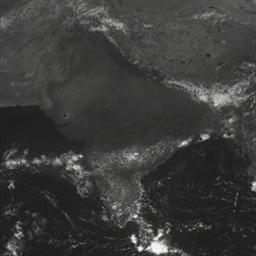

In [ ]:
cv2_imshow(interpolated_frame[0]*255.0)

array([[[ 65,  45,  58],
        [ 60,  54,  63],
        [ 55,  52,  64],
        ...,
        [ 89,  90,  96],
        [ 90, 114, 120],
        [144,  94, 111]],

       [[ 63,  56,  54],
        [ 60,  71,  54],
        [ 52,  66,  59],
        ...,
        [ 88,  99,  81],
        [ 89, 136, 109],
        [121, 109, 102]],

       [[ 56,  52,  54],
        [ 59,  67,  62],
        [ 54,  56,  62],
        ...,
        [ 89,  79,  87],
        [ 71, 103,  95],
        [131,  87, 107]],

       ...,

       [[ 36,  28,  38],
        [ 41,  48,  36],
        [ 38,  38,  48],
        ...,
        [ 38,  40,  41],
        [ 37,  40,  37],
        [ 32,  24,  32]],

       [[ 62,  49,  51],
        [ 43,  47,  43],
        [ 48,  62,  73],
        ...,
        [ 38,  46,  44],
        [ 40,  50,  53],
        [ 44,  37,  40]],

       [[ 40,  48,  45],
        [ 38,  33,  37],
        [ 40,  40,  53],
        ...,
        [ 33,  33,  31],
        [ 33,  44,  36],
        [ 46,  35,  35]]], dtype=uint8)
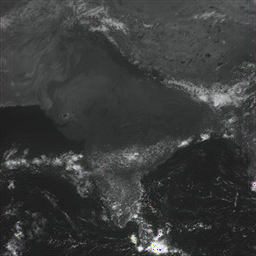

In [ ]:
images[1]

In [ ]:
import imageio
images = [img1,(interpolated_frame[0]*255.0).astype(np.uint8),img2]


In [ ]:
imageio.mimsave('output.gif', images, duration=1,fps=3)

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

# Load pre-trained VGG-19 model
vgg = VGG19(weights="imagenet", include_top=False)

# Define the perceptual loss model (up to relu4_4 layer as suggested in the paper)
perceptual_model = Model(inputs=vgg.input, outputs=vgg.get_layer("block4_conv4").output)
perceptual_model.trainable = False  # Freeze the VGG model
# Perceptual loss function
def perceptual_loss(y_true, y_pred):
    # Scale pixel values to match VGG's expected input range
    y_true_vgg = tf.keras.applications.vgg19.preprocess_input(y_true * 255.0)
    y_pred_vgg = tf.keras.applications.vgg19.preprocess_input(y_pred * 255.0)

    # Compute feature activations
    true_features = perceptual_model(y_true_vgg)
    pred_features = perceptual_model(y_pred_vgg)

    # L2 loss on features
    return tf.reduce_mean(tf.square(true_features - pred_features))


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
def combined_loss(y_true, y_pred, alpha=0.8):
    return alpha * l1_loss(y_true, y_pred) + (1 - alpha) * perceptual_loss(y_true, y_pred)

model.compile(optimizer='adam', loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, alpha=0.8))
model.fit(x=[X[:, :, :, :3], X[:, :, :, 3:]],y=Y, epochs=50,batch_size=16)


In [ ]:
model.fit(x=[X[:, :, :, :3], X[:, :, :, 3:]],y=Y, epochs=50,batch_size=16)

In [ ]:
model.fit(x=[X[:, :, :, :3], X[:, :, :, 3:]],y=Y, epochs=100,batch_size=16)

In [ ]:
import numpy as np
import imageio
import time

# Video parameters
fps = 3  # Frames per second
duration = 5  # Duration of the video in seconds
num_frames = int(fps * duration)  # Total number of frames

# Output video
output_file = 'output_video.mp4'
writer = imageio.get_writer(output_file, fps=fps)

# Loop through the images and save to the video
start_time = time.time()
for i in range(num_frames):
    frame = images[i % len(images)]  # Cycle through the images
    writer.append_data(frame)

# Close the writer
writer.close()

print(f"Video saved as {output_file}")


Video saved as output_video.mp4


In [ ]:
# Save the trained model to a directory
model.save('sepconv-model.h5')
print("Model saved successfully!")

Model saved successfully!


In [ ]:
model.save('sep_conv.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: model.compile(optimizer='adam', loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, alpha=0.8))

  return {key: serialize_keras_object(value) for key, value in obj.items()}


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp /content/drive/MyDrive/dfi_model.zip /content
# !ls content/training/3 |wc -l

Mounted at /content/drive


# **model  conversion to tfjs**

In [4]:
from tensorflow.keras.models import load_model

# Load the model saved in HDF5 format
model = load_model('sep_conv.keras', custom_objects={'SeparableConvLayer': SeparableConvLayer},safe_mode=False)
print("HDF5 model loaded successfully!")


HDF5 model loaded successfully!


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
model.export('sepconv-model')

Saved artifact at 'sepconv-model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='Frame_I1'), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='Frame_I2')]
Output Type:
  TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)
Captures:
  140442762480272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140442762482912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140442762485376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140442762479392: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [5]:
import cv2
import  numpy as np
img1 = cv2.imread('i0.png')
img2 = cv2.imread('i2.png')
def preprocess_frame(img):
    frame = img / 255.0
    return np.expand_dims(frame, axis=0)


In [6]:
i0 = preprocess_frame(img1)
i2 = preprocess_frame(img2)

interpolated_frame = model.predict([i0, i2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


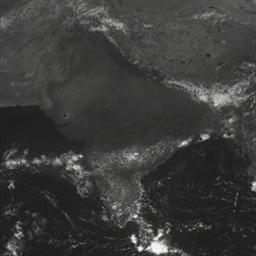

In [7]:
from google.colab.patches import cv2_imshow

cv2_imshow(interpolated_frame[0]*255.0)

In [8]:
interpolated_frame.shape

(1, 256, 256, 3)

In [ ]:
!pip install tensorflowjs

In [ ]:
!mkdir tfjs/

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model /content/sepconv-model tfjs/sepconv-model

2024-12-02 14:01:58.162784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733148118.182703    9649 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733148118.188746    9649 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2024-12-02 14:02:01.142924: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1733148121.143090    9649 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [ ]:
!zip tfjs_model.zip -r /content/tfjs/*

  adding: content/tfjs/sepconv-model/ (stored 0%)
  adding: content/tfjs/sepconv-model/model.json (deflated 86%)
  adding: content/tfjs/sepconv-model/group1-shard1of1.bin (deflated 5%)
